In [1]:
import pickle
from collections import namedtuple

import pandas as pd
from pandas.tim
import numpy as np
from numpy import pi as PI
import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as pl
import matplotlib.dates as mdates
from matplotlib import rcParams

from sklearn.preprocessing import StandardScaler

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
% matplotlib inline
rcParams['xtick.major.size'] = 8
rcParams['xtick.minor.size'] = 4
rcParams['xtick.minor.visible'] = True
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['axes.labelsize'] = 16
rcParams['axes.titlesize'] = 18

In [237]:
years = mdates.YearLocator(day=15)
years2 = mdates.YearLocator(base=2, day=15)
months = mdates.MonthLocator(bymonthday=15)

In [27]:
chl_file = './dataJar/seawifs_chl_monthly_15sosectors_repro2018.dat'
df = pd.read_csv(chl_file, delim_whitespace=True, parse_dates=[[0, 1 ,2]], index_col=0)
dfr = df.resample('MS').mean()
dfr.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 160 entries, 1997-09-01 to 2010-12-01
Freq: MS
Data columns (total 15 columns):
IOSTZ      155 non-null float64
IOSAZ      155 non-null float64
IOPFZ      155 non-null float64
IOAAZ      148 non-null float64
IOSAACZ    123 non-null float64
POSTZ      155 non-null float64
POSAZ      155 non-null float64
POPFZ      124 non-null float64
POAAZ      118 non-null float64
POSAACZ    99 non-null float64
AOSTZ      153 non-null float64
AOSAZ      153 non-null float64
AOPFZ      152 non-null float64
AOAAZ      139 non-null float64
AOSAAC     126 non-null float64
dtypes: float64(15)
memory usage: 20.0 KB


In [241]:
pd.__version__

'0.23.0'

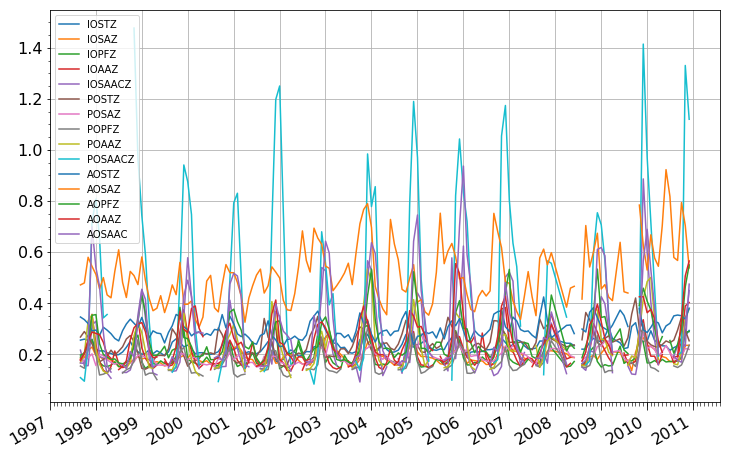

In [31]:
f, ax = pl.subplots(figsize=(12, 8))
df.plot(ax=ax);
ax.xaxis_date()
ax.xaxis.set_major_locator(years)
ax.xaxis.set_minor_locator(months)
ax.set_xlabel('')
ax.grid()

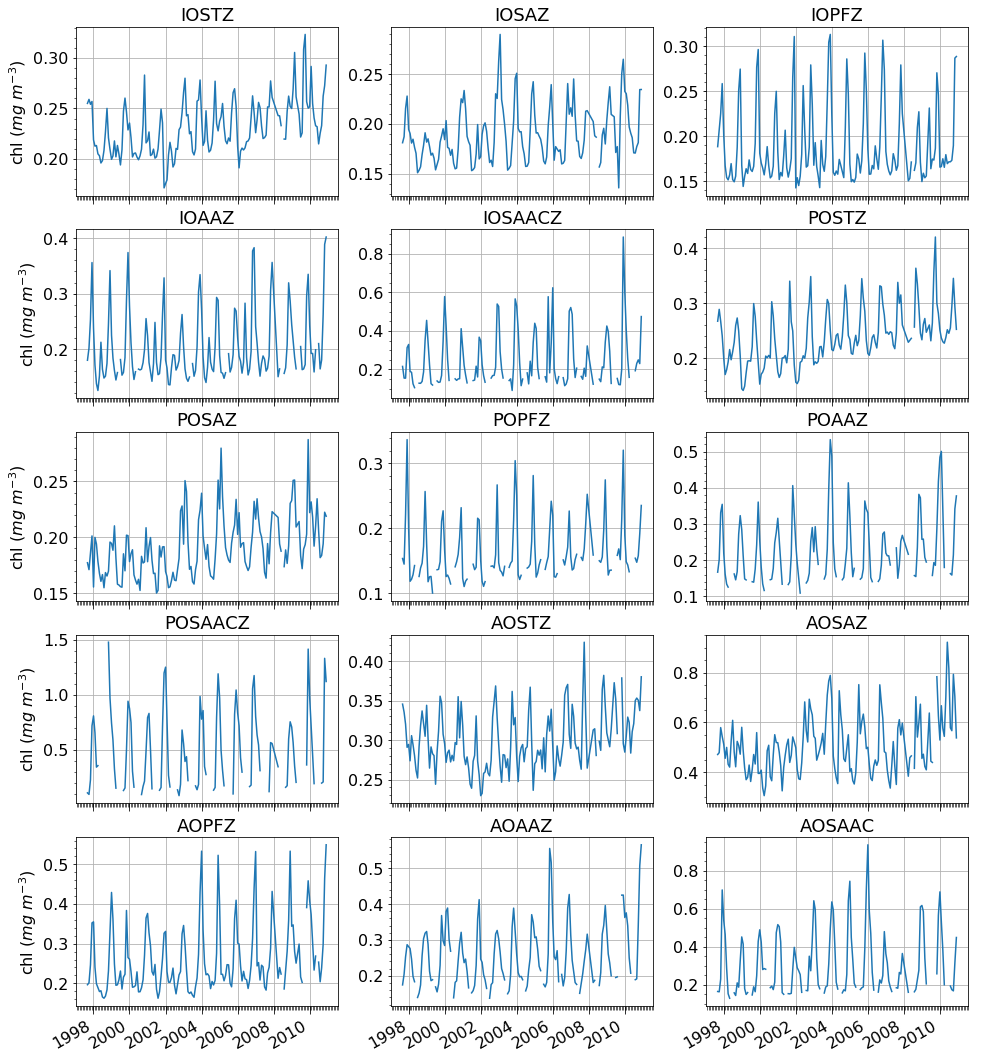

In [239]:
f, axs = pl.subplots(figsize=(16, 20), ncols=3, nrows=5, sharex=True)
axs = axs.ravel()
for i, (axi, col) in enumerate(zip(axs, dfr.columns)):
    df[col].plot(ax=axi)
    axi.xaxis_date()
    axi.xaxis.set_major_locator(years2)
    axi.xaxis.set_minor_locator(months)
    axi.set_xlabel('')
    axi.grid()
    axi.set_title(col)
    if i % 3 == 0:
        axi.set_ylabel('chl ($mg\ m^{-3}$)')
f.savefig('./figJar/ts15.png', dpi=300)

### <u>Preamble: Model a single time series</u> 
I use a single timeseries first. I use an additive model with three sub-components:
1. I use a global trend model to capture the trend
2. I use a first a single sinuoid, then a fourier series to fit seasonality
3. I use an AR(1) model to fit the residual
4. There is one NaN in the series; it is imputed on the fly

In [129]:
y = dfr.IOSTZ.values
ymsk = dfr.IOSTZ.isnull().values
x = np.arange(y.shape[0])

#### Make masked array and Standardize the data

In [43]:
y_w_nan = np.ma.array(data=y, mask=ymsk, fill_value=-999)
nan_scaler = namedtuple('nan_scaler', ['mean_', 'std_'])
nan_scaler.mean_ = y_w_nan.mean()
nan_scaler.std_ = y_w_nan.std()
y_w_nan_s = (y_w_nan - nan_scaler.mean_) / nan_scaler.std_

In [63]:
def plot_component(axi, x, y, hpd_=None, obs=None, line_label=None, y_axis_label=None,
                  ax_title=None):
    
    if isinstance(obs, np.ndarray):
        axi.plot(x, obs, color='k', label='observations')
    axi.plot(x, y, color='darkblue', label=line_label)
    if isinstance(hpd_, np.ndarray):
        axi.fill_between(x, hpd_[:, 0], hpd_[:, 1], color='steelblue',
                         alpha=0.5, label='95% CI')
    if y_axis_label:
        axi.set_ylabel(y_axis_label)
    axi.legend()
    if ax_title:
        axi.set_title(ax_title)
    axi.xaxis_date()
    axi.xaxis.set_major_locator(years)
    axi.xaxis.set_minor_locator(months)
    axi.tick_params(axis='x', labelrotation=30)
    axi.grid()

def inverse_transform(X):
    return (nan_scaler.std_ * X + nan_scaler.mean_)

# test inverse_transform
a = inverse_transform(y_w_nan_s)
np.testing.assert_array_equal(y_w_nan, a)

#### <u> Seasonality: Single sinusoid with inferred wavelength</u>

In [45]:
wl_lower = 11 / (2 * np.pi)
wl_upper = 13 / (2 * np.pi)

In [73]:
with pm.Model() as m0:
    """This model includes missing data imputation"""
    # overall estimation
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    
    # seasonality estimation
    thresh = pm.Uniform('thresh', 0, 11)
    amp = pm.Uniform('amp', 0, 1)
    wl_ = pm.Uniform('wl', wl_lower, wl_upper)
    season = pm.Deterministic('season', amp * tt.cos((x - thresh)/ wl_))
    
    
    # trend estimation
    slp = pm.Normal('slope', 0, 1)
    itc = pm.Normal('intercept', 0, 1)
    trend = pm.Deterministic('trend', itc + slp * x)
    
    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1)
    tau_ = pm.Gamma('tau', 10, 3)
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y.size)
    e_t = pm.Normal('e_t', 0, 1, shape=y.size)
    mu_ = trend + season + e_t
    mu_ = pm.Deterministic('mu', trend + season)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_w_nan_s)

In [119]:
with m0:
    trace_0 = pm.sample(5000, tune=20000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_lik_missing, intercept, slope, wl_interval__, amp_interval__, thresh_interval__, lam_log__, nuMinusOne_log__]
100%|██████████| 25000/25000 [01:10<00:00, 354.96it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


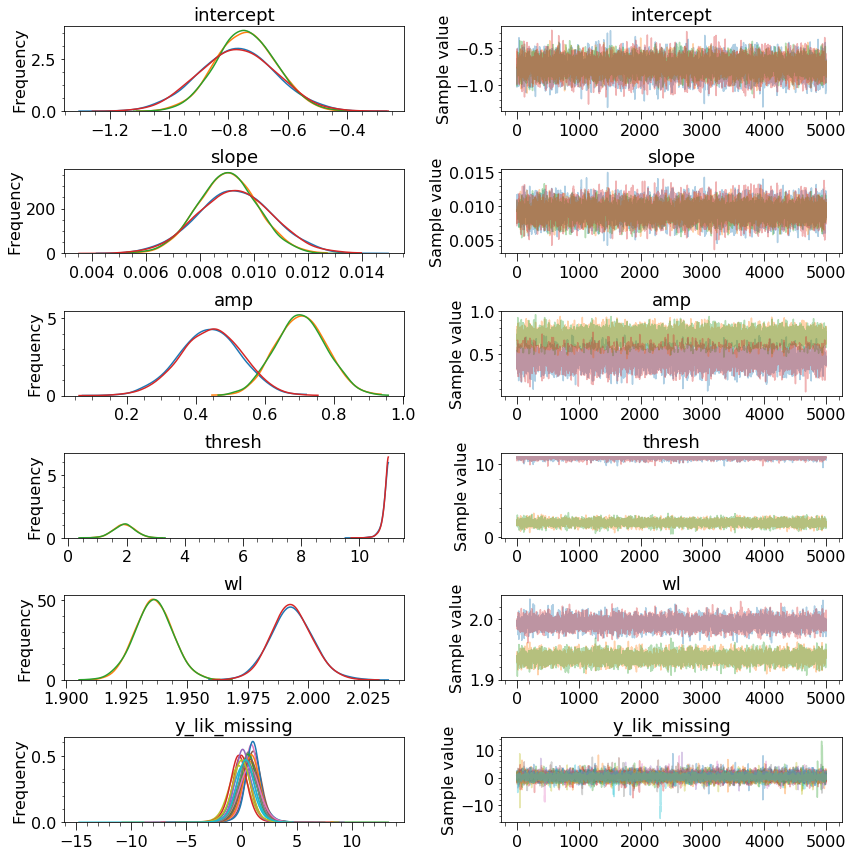

In [122]:
vars_ = ['intercept', 'slope', 'amp', 'thresh', 'wl', 'y_lik_missing']
pm.traceplot(trace_0, varnames=vars_);

In [83]:
def plot_ts_components(trace, df_, y_obs, residual=False):
    ts_mod = trace.get_values('mu')
    ts_mod_mu = ts_mod.mean(axis=0)
    ts_mod_hpd = pm.hpd(ts_mod)
    ts_mod_trend = trace.get_values('trend')
    ts_mod_trend_mu = ts_mod_trend.mean(axis=0)
    ts_mod_trend_hpd = pm.hpd(ts_mod_trend)
    ts_mod_season = trace.get_values('season')
    ts_mod_season_mu = ts_mod_season.mean(axis=0)
    ts_mod_season_hpd = pm.hpd(ts_mod_season)

    mod_mu_us = inverse_transform(ts_mod_mu)
    mod_hpd_us = inverse_transform(ts_mod_hpd)
    mod_trend_hpd_us = inverse_transform(ts_mod_trend_hpd)
    mod_trend_mu_us = inverse_transform(ts_mod_trend_mu)
    mod_season_hpd_us = inverse_transform(ts_mod_season_hpd)
    mod_season_mu_us =inverse_transform(ts_mod_season_mu)
    if residual:
        ts_mod_ar1 = trace.get_values('ar1')
        ts_mod_ar1_mu = ts_mod_ar1.mean(axis=0)
        ts_mod_ar1_hpd = pm.hpd(ts_mod_ar1)
        mod_ar1_hpd_us = inverse_transform(ts_mod_ar1_hpd)
        mod_ar1_mu_us = inverse_transform(ts_mod_ar1_mu)
        nrows=4
    else: 
        nrows=3
    f, ax = pl.subplots(nrows=nrows, sharex=True, figsize=(12, nrows*5))
    plot_component(ax[0], df_.index, ts_mod_mu, hpd_=ts_mod_hpd,
                   obs=y_obs, line_label='model_mean',
                   y_axis_label='chl $(mg m^-3)$', ax_title='All Components')
    plot_component(ax[1], df_.index, ts_mod_trend_mu, hpd_=ts_mod_trend_hpd,
                   line_label='mean', y_axis_label='chl $(mg m^-3)$',
                   ax_title='Trend')
    plot_component(ax[2], df_.index, ts_mod_season_mu, hpd_=ts_mod_season_hpd,
                   line_label='mean', y_axis_label='chl $(mg m^-3)$',
                   ax_title='Season')
    if residual:
        plot_component(ax[3], df_.index, ts_mod_ar1_mu, hpd_=ts_mod_ar1_hpd,
                       line_label='mean', y_axis_label='chl $(mg m^-3)$',
                       ax_title='AR1')

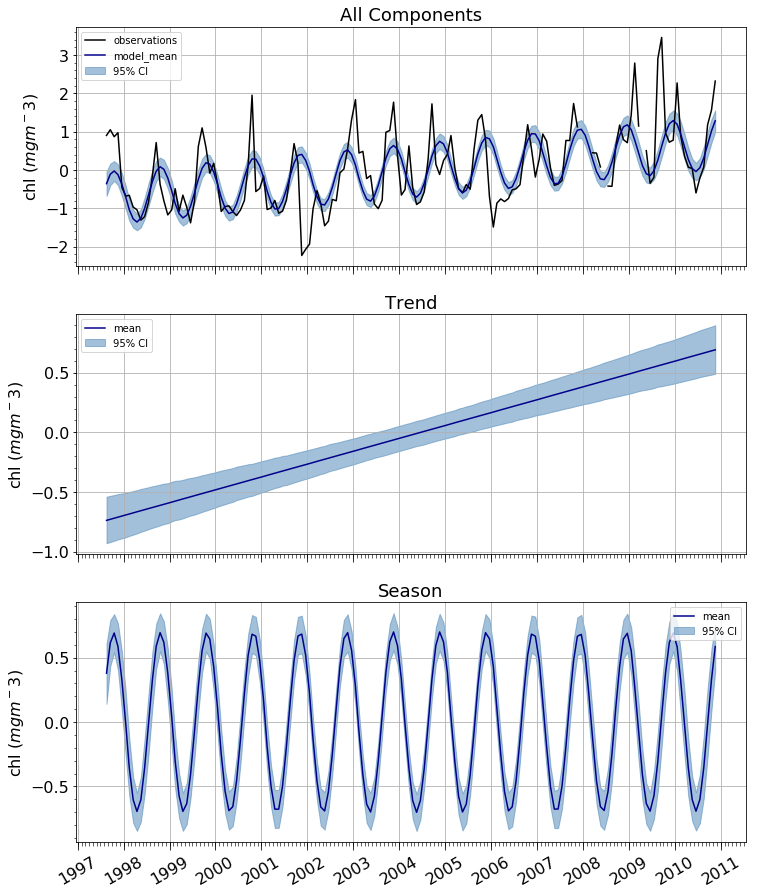

In [84]:
plot_ts_components(trace_0, df_=dfr, y_obs=y_w_nan_s)

In [104]:
def ts_model_with_fourier_seasonality(n_fourier_comps=4):
    wls = [2*np.pi *k / 12 for k in range(1, n_fourier_comps+1)]
    sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                          for wli in wls]).reshape(n_fourier_comps*2, -1).T
    with pm.Model() as mf:
        """This model includes missing data imputation"""
        # overall estimation
        nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
        nu_ = nuMinusOne + 1
        lam_ = pm.Gamma('lam', 10, 2)

        # seasonality estimation
        f_coefs = pm.Laplace('fourier_coefs', mu=0, b=1, shape=(n_fourier_comps*2))
        season = pm.Deterministic('season', tt.dot(sinusoids, f_coefs))


        # trend estimation
        slp = pm.Normal('slope', 0, 1)
        itc = pm.Normal('intercept', 0, 1)
        trend = pm.Deterministic('trend', itc + slp * x)

        # residual estimation
        k_ = pm.Uniform('k', -1.1, 1.1)
        tau_ = pm.Gamma('tau', 10, 3)
        ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=y.size)
        mu_ = pm.Deterministic('mu', trend + season + ar1)
        y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_w_nan_s)
    return mf

In [106]:
m1 = ts_model_with_fourier_seasonality(n_fourier_comps=4)
with m1:
    trace_1 = pm.sample(5000, tune=20000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_lik_missing, ar1, tau_log__, k_interval__, intercept, slope, fourier_coefs, lam_log__, nuMinusOne_log__]
100%|██████████| 25000/25000 [03:29<00:00, 119.35it/s]
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [111]:
vars_ = ['intercept', 'slope', 'fourier_coefs', 'k', 'tau', 'lam', 'y_lik_missing']

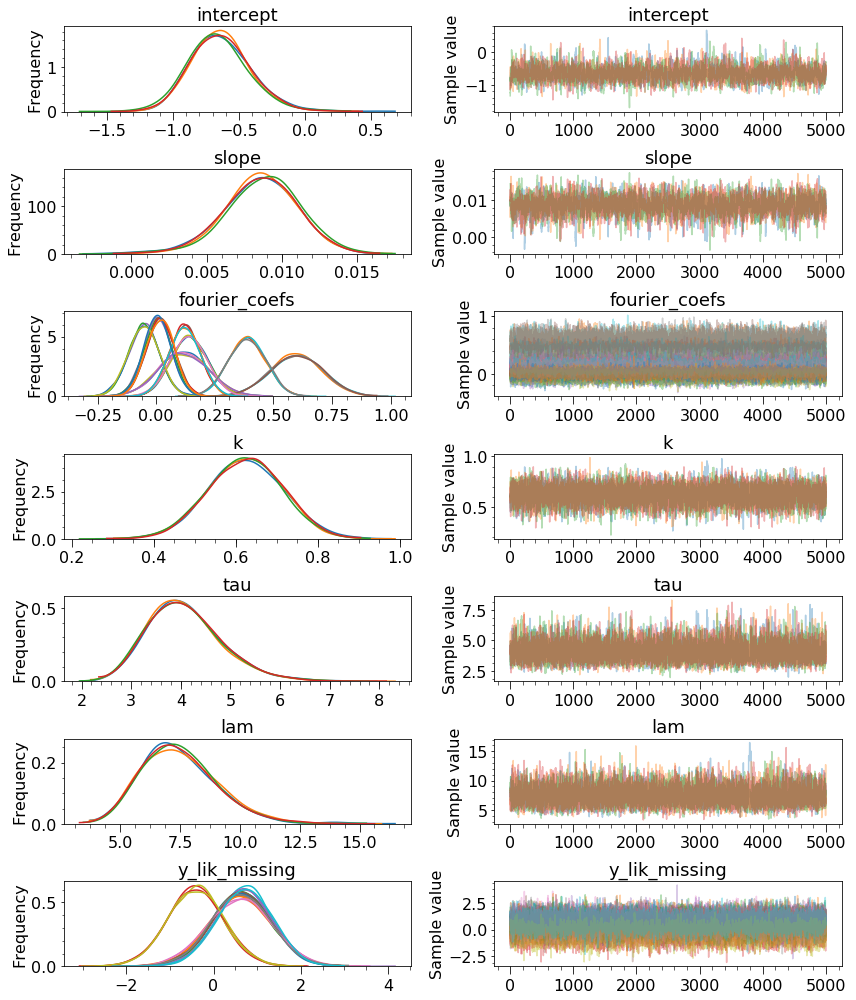

In [112]:
pm.traceplot(trace_1, varnames=vars_);

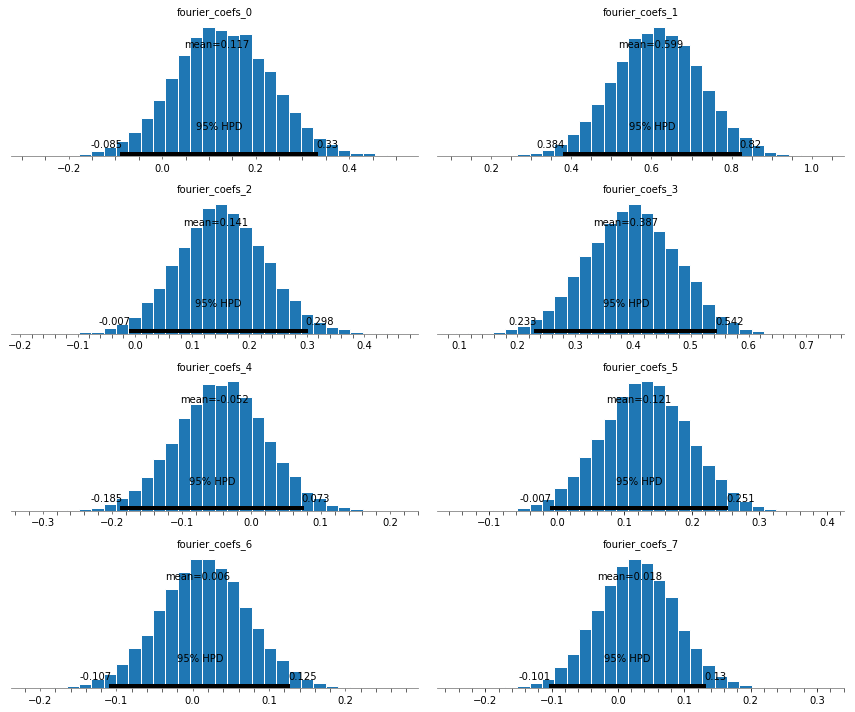

In [113]:
pm.plot_posterior(trace_1, varnames=['fourier_coefs']);

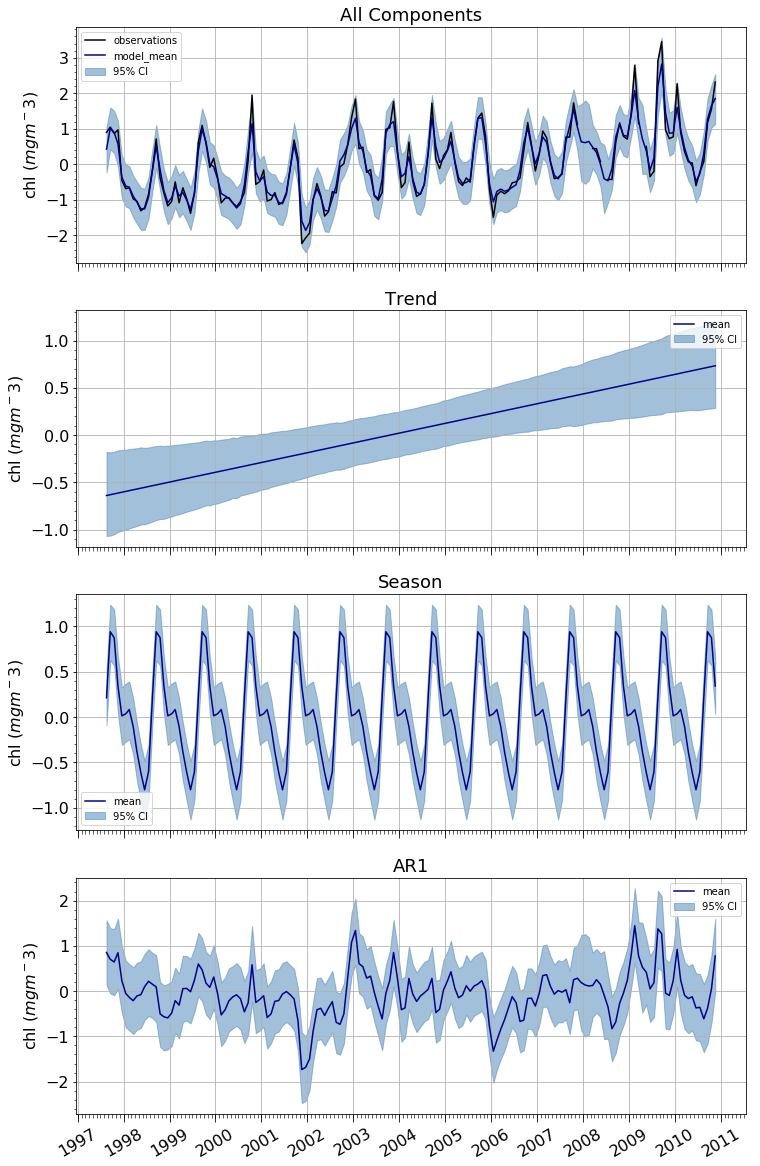

In [114]:
plot_ts_components(trace_1, df_=dfr, y_obs=y_w_nan_s, residual=True)

In [107]:
m2 = ts_model_with_fourier_seasonality(n_fourier_comps=2)
with m2:
    trace_2 = pm.sample(5000, tune=20000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [y_lik_missing, ar1, tau_log__, k_interval__, intercept, slope, fourier_coefs, lam_log__, nuMinusOne_log__]
100%|██████████| 25000/25000 [03:34<00:00, 116.72it/s]
There were 98 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.4745052310835237, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9235368402906672, but should be close to 0.8. Try to increase the number of tuning steps.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7045764721408369, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


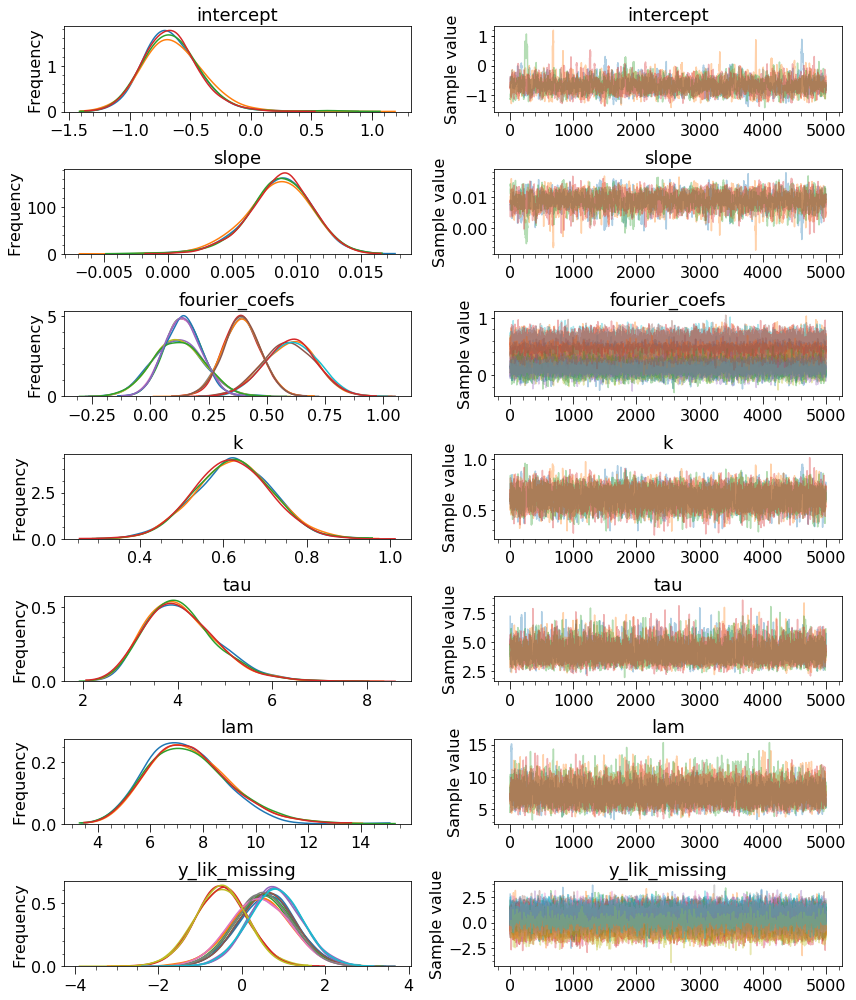

In [115]:
pm.traceplot(trace_2, varnames=vars_);

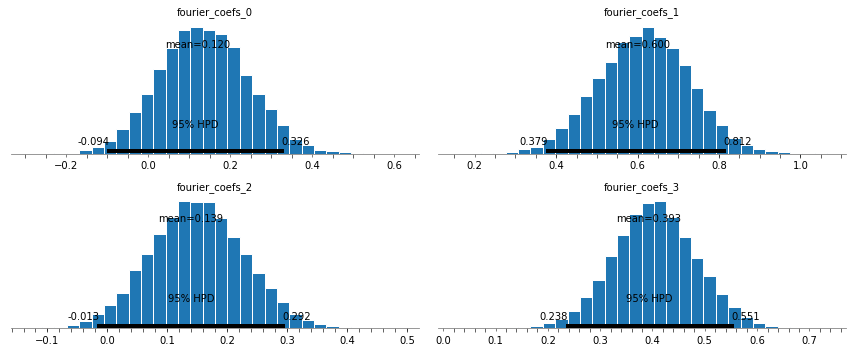

In [123]:
pm.plot_posterior(trace_2, varnames=['fourier_coefs']);

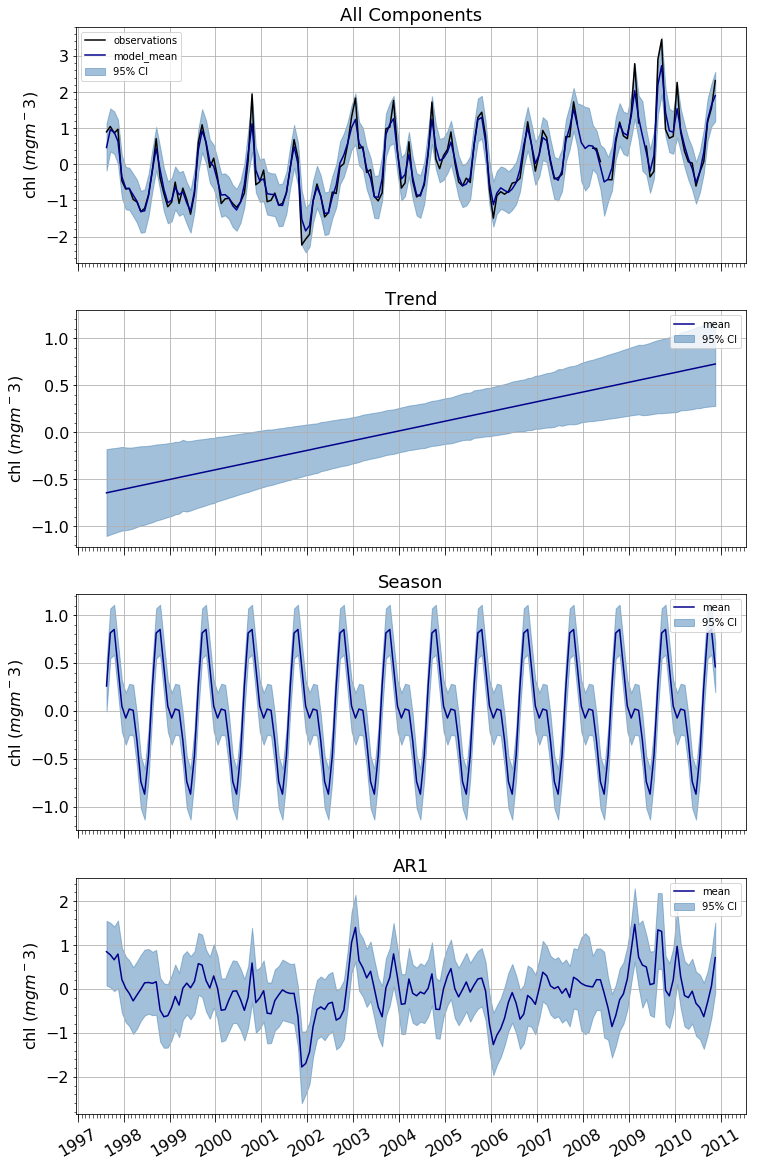

In [121]:
plot_ts_components(trace_2, df_=dfr, y_obs=y_w_nan_s, residual=True);

In [116]:
m1.name = 'm1'
m2.name = 'm2'
m0.name = 'm0'

In [117]:
d_comp = pm.compare({m1: trace_1, m2: trace_2, m0: trace_0})
d_comp

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:211: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
m1,229.81,69.85,0,0.65,16.7,0,1
m2,230.66,69.52,0.85,0.35,17.65,3.32,1
m0,345.41,7.06,115.6,0,25.91,18.18,0


In [118]:
d_comp_loo = pm.compare({m1: trace_1, m2: trace_2, m0: trace_0}, ic='LOO')
d_comp_loo

/accounts/ekarakoy/anaconda3/envs/machine_learning/lib/python3.6/site-packages/pymc3/stats.py:292: UserWarning: Estimated shape parameter of Pareto distribution is
        greater than 0.7 for one or more samples.
        You should consider using a more robust model, this is because
        importance sampling is less likely to work well if the marginal
        posterior and LOO posterior are very different. This is more likely to
        happen with a non-robust model and highly influential observations.
  happen with a non-robust model and highly influential observations.""")


,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
m2,263.43,85.9,0,0.97,19.56,0,1
m1,266.6,88.25,3.17,0.03,19.34,3.71,1
m0,345.44,7.07,82.01,0,25.92,18.11,0


#### <u>Hierarchical Model, using m2 (global trend + 2-fourier component season + AR(1) residual)</u>

In [134]:
# extract data from dataframe and convert to masked array for automatic imputation
y_15 = dfr.values
y_15_msk = dfr.isnull().values

In [136]:
y_ma_15 = np.ma.array(data=y_15, mask=y_15_msk, fill_value=-999)
nan_scaler_15 = namedtuple('nan_scaler', ['mean_', 'std_'])
nan_scaler_15.mean_ = y_ma_15.mean(axis=0)
nan_scaler_15.std_ = y_ma_15.std(axis=0)
y_ma_15_s = (y_ma_15 - nan_scaler_15.mean_) / nan_scaler_15.std_

In [138]:
pd.DataFrame(y_ma_15_s).describe().T

,count,mean,std,min,25%,50%,75%,max
0,155.0,1.489848e-15,1.003241,-2.232169,-0.795164,-0.160008,0.710315,3.454114
1,155.0,5.042561e-16,1.003241,-1.955107,-0.733212,-0.203044,0.622083,3.618787
2,155.0,1.661753e-16,1.003241,-1.073635,-0.669463,-0.425273,0.360701,2.917724
3,148.0,4.800964e-17,1.003396,-1.260033,-0.676329,-0.372900,0.341858,3.231669
4,123.0,-2.166289e-17,1.004090,-1.084766,-0.675358,-0.414200,0.546333,4.442537
5,155.0,-3.667317e-16,1.003241,-1.978797,-0.710166,-0.111779,0.550916,3.628900
6,155.0,1.008512e-15,1.003241,-1.564206,-0.778790,-0.097036,0.509051,3.632179
7,124.0,3.796246e-16,1.004057,-1.364250,-0.609384,-0.326515,0.230791,3.813910
8,118.0,1.129040e-16,1.004264,-1.309700,-0.813097,-0.265141,0.477113,3.329518
9,99.0,1.794300e-17,1.005089,-1.213708,-0.934956,-0.220059,0.708174,2.694897


In [139]:
pd.DataFrame(y_ma_15_s).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 15 columns):
0     155 non-null float64
1     155 non-null float64
2     155 non-null float64
3     148 non-null float64
4     123 non-null float64
5     155 non-null float64
6     155 non-null float64
7     124 non-null float64
8     118 non-null float64
9     99 non-null float64
10    153 non-null float64
11    153 non-null float64
12    152 non-null float64
13    139 non-null float64
14    126 non-null float64
dtypes: float64(15)
memory usage: 18.8 KB


In [240]:
dfr.isnull().sum()

IOSTZ       5
IOSAZ       5
IOPFZ       5
IOAAZ      12
IOSAACZ    37
POSTZ       5
POSAZ       5
POPFZ      36
POAAZ      42
POSAACZ    61
AOSTZ       7
AOSAZ       7
AOPFZ       8
AOAAZ      21
AOSAAC     34
dtype: int64

In [140]:
sinusoids.shape

(160, 8)

In [168]:
n_fourier_comps=2
wls = [2*np.pi *k / 12 for k in range(1, n_fourier_comps+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(n_fourier_comps*2, -1).T

In [171]:
x = np.arange(y_15.shape[0])
x = x.reshape(-1,1)

In [172]:
x.shape

(160, 1)

In [244]:
del n_fourier

In [252]:
n_regions = y_15.shape[1]
n_fourier_comps=2
wls = [2*np.pi *k / 12 for k in range(1, n_fourier_comps+1)]
sinusoids = np.array([[np.cos(wli*x), np.sin(wli*x)] 
                      for wli in wls]).reshape(n_fourier_comps*2, -1).T
with pm.Model() as hmf:
    """This model includes missing data imputation"""
    # overall estimation
    nuMinusOne = pm.Exponential('nuMinusOne', 1/29)
    nu_ = nuMinusOne + 1
    lam_ = pm.Gamma('lam', 10, 2)
    
    # hyperpriors: 
    hyp_fourcoef_mu = pm.Normal('hyp_fourcoef_mu', mu=0, sd=10)
    hyp_fourcoef_sd  = pm.HalfCauchy('hyp_fourcoef_b', beta=5)
    hyp_slp_mu = pm.Normal('hyp_slp_mu', mu=0, sd=10)
    hyp_slp_sd = pm.HalfCauchy('hyp_slp_sd', beta=5)
    hyp_itc_mu = pm.Normal('hyp_itc_mu', mu=0, sd=10)
    hyp_itc_sd = pm.HalfCauchy('hyp_itc_sd', beta=5)
    #hyp_tau_alpha = pm.HalfNormal('hyp_tau_alpha', sd=5)
    #hyp_tau_beta = pm.HalfNormal('hyp_tau_beta', sd=5)
    # seasonality estimation
    f_coefs_offsets = pm.Normal('fco', 0, 1, shape=(n_fourier_comps*2, n_regions))
    f_coefs = pm.Deterministic('f_coefs',
                               hyp_fourcoef_mu + f_coefs_offsets * hyp_fourcoef_sd
                              )
    season = pm.Deterministic('season', tt.dot(sinusoids, f_coefs))


    # trend estimation
    slp_offset = pm.Normal('slp_offset', mu=0, sd=1, shape=(1, n_regions))
    slp = pm.Deterministic('slope', hyp_slp_mu + slp_offset * hyp_slp_sd)
    #slp = pm.Normal('slope', mu=hyp_slp_mu, sd=hyp_slp_std, shape=(1, n_regions))
    itc_offset = pm.Normal('itc_offset', mu=0, sd=1, shape=(1, n_regions))
    itc = pm.Deterministic('intercept', hyp_itc_mu + itc_offset * hyp_itc_sd)
    #itc = pm.Normal('intercept', mu=hyp_itc_mu, sd=hyp_itc_std, shape=(1, n_regions))
    trend = pm.Deterministic('trend', itc + tt.dot(x, slp))

    # residual estimation
    k_ = pm.Uniform('k', -1.1, 1.1, shape=(1, n_regions))
    tau_ = pm.Gamma('tau', alpha=10, beta=3, shape=(1, n_regions))
    ar1 = pm.AR1('ar1', k=k_, tau_e=tau_, shape=(x.size, n_regions))
    mu_ = pm.Deterministic('mu', trend + season + ar1)
    y_lik = pm.StudentT('y_lik', mu=mu_, lam=lam_, nu=nu_, observed=y_ma_15_s)

In [261]:
trace_hmf.get_sampler_stats('depth').shape

(4000,)

In [264]:
with hmf:
    trace_hmf = pm.sample(5000, tune=2000, nuts_kwargs=dict(target_accept=0.95), 
                         chains=2, cores=2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [y_lik_missing, ar1, tau_log__, k_interval__, itc_offset, slp_offset, fco, hyp_itc_sd_log__, hyp_itc_mu, hyp_slp_sd_log__, hyp_slp_mu, hyp_fourcoef_b_log__, hyp_fourcoef_mu, lam_log__, nuMinusOne_log__]
100%|██████████| 7000/7000 [22:04<00:00,  5.28it/s]
The acceptance probability does not match the target. It is 0.8841164401996321, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 755 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7659309377992856, but should be close to 0.95. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The gelman-ru

In [181]:
pm.summary(trace_hmf, varnames=['slope', 'intercept'])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
slope__0_0,0.007128,0.001017,0.000062,0.005096,0.009221,42.732624,1.052937
slope__0_1,0.005312,0.000735,0.000012,0.003960,0.006791,4061.538365,0.999948
slope__0_2,0.002017,0.000802,0.000024,0.000542,0.003637,567.650524,1.002488
slope__0_3,0.003223,0.000702,0.000017,0.001801,0.004536,1710.814318,1.000633
slope__0_4,0.002535,0.000752,0.000016,0.000975,0.003989,2519.853544,1.001063
slope__0_5,0.007588,0.001012,0.000063,0.005458,0.009412,26.621958,1.083205
slope__0_6,0.007894,0.000826,0.000028,0.006303,0.009492,689.071986,1.001391
slope__0_7,0.003230,0.000757,0.000011,0.001692,0.004685,4404.704094,0.999624
slope__0_8,0.003592,0.000778,0.000012,0.002039,0.005067,4189.951295,0.999576
slope__0_9,0.002269,0.000852,0.000019,0.000625,0.003944,1998.109780,1.001454


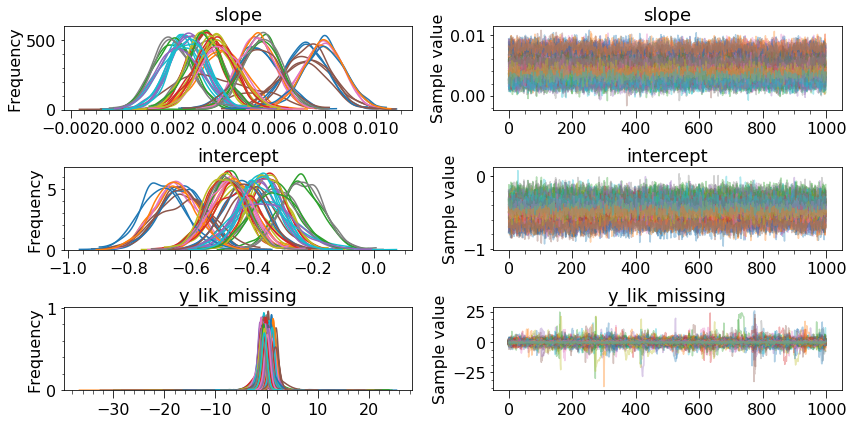

In [182]:
pm.traceplot(trace_hmf, varnames=['slope', 'intercept', 'y_lik_missing']);

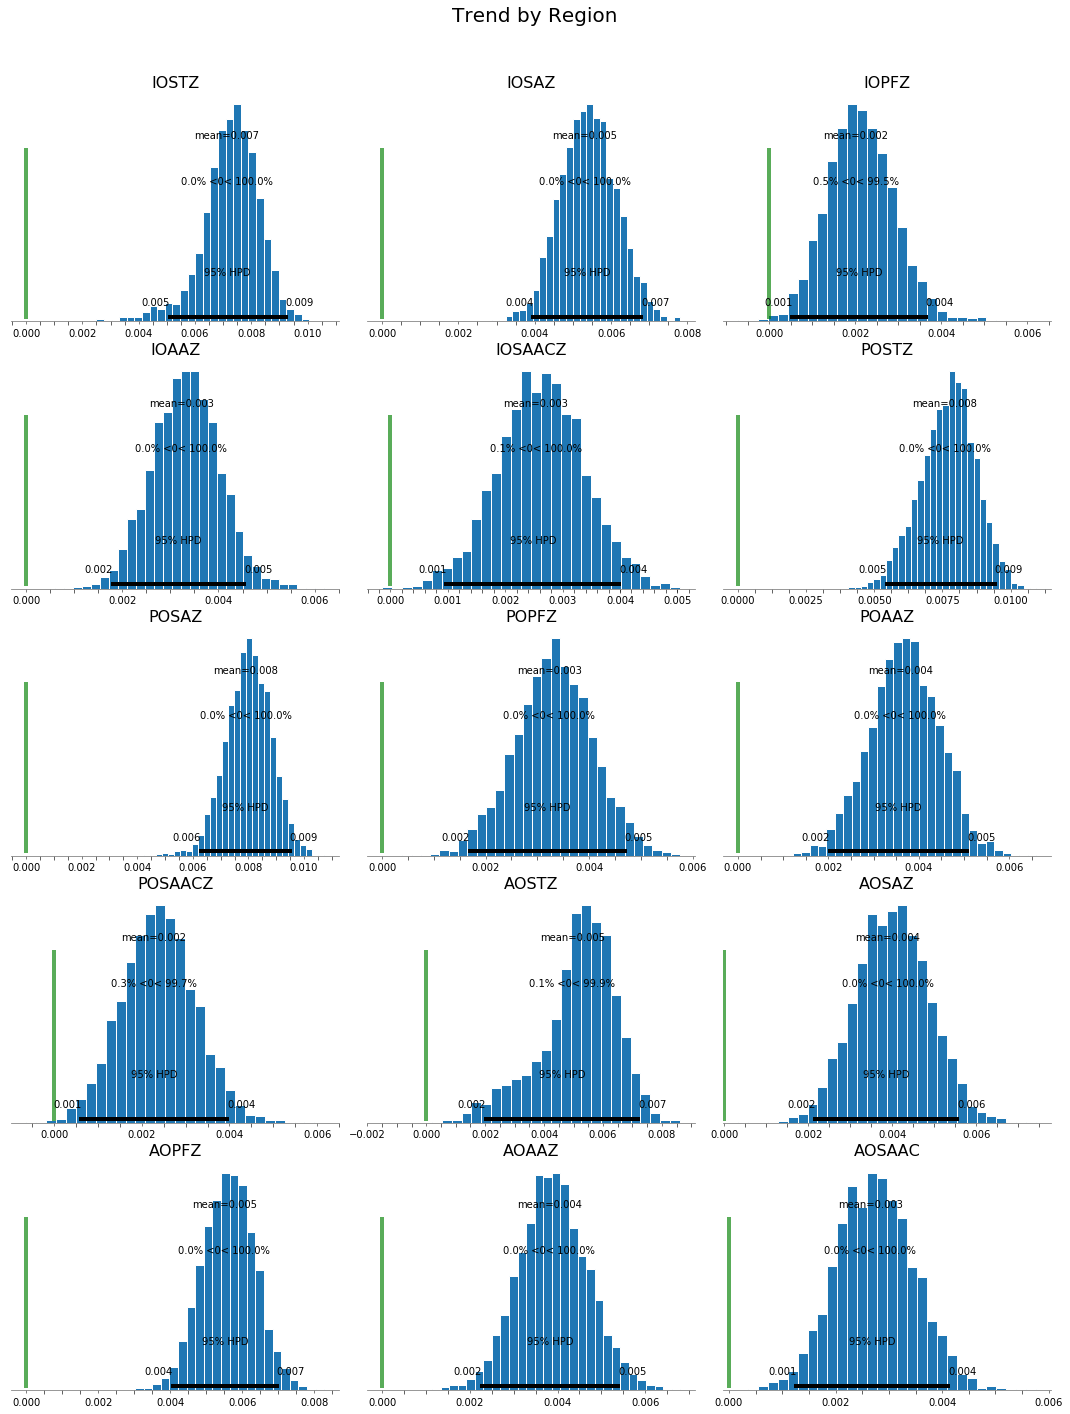

In [218]:
f, axs = pl.subplots(figsize=(15,28), nrows=5, ncols=3)
f.suptitle('Trend by Region', fontsize=20)

axs = axs.ravel()
pm.plot_posterior(trace_hmf, varnames=['slope'], ref_val=0, ax=axs);
for ax, col in zip(axs, dfr.columns):
    ax.set_title(f'{col}', fontsize=16)
pl.subplots_adjust(top=0.92)
f.savefig('./figJar/SO15_Trends.png', dpi=300)

In [226]:
y_lik_missing = trace_hmf.get_values('y_lik_missing')

In [227]:
y_lik_missing

(4000, 290)

IOSTZ       5
IOSAZ       5
IOPFZ       5
IOAAZ      12
IOSAACZ    37
POSTZ       5
POSAZ       5
POPFZ      36
POAAZ      42
POSAACZ    61
AOSTZ       7
AOSAZ       7
AOPFZ       8
AOAAZ      21
AOSAAC     34
dtype: int64

In [231]:
dfr.size

2400